## Setup

In [1]:
# xNorm histogram fitting based on numerical xNorm described in fminsearch

# SET UP YOUR PROJECT DIRECTORY HERE
from pathlib import Path

# SET YOUR PROJECT DIRECTORY HERE
root_dir = 'C:\\Users\\sangjin\\Downloads\\xNormGH'

# YOUR DATA LOCATION
fitPath = f'{root_dir}\\xnormfit\\data'

import sys
sys.path.append(root_dir)

In [2]:
%matplotlib inline

import typing, os
import pandas as pd
import numpy as np
import scipy
import time
import matplotlib
import matplotlib.pyplot as plt

import scipy.io as sio
from scipy.optimize import fmin, minimize
from scipy.interpolate import interp1d
from scipy.stats import norm, mode

import pymcmcstat

from xnormfit.src.analyze import run_analysis

In [3]:
scipy.__version__, np.__version__, matplotlib.__version__, pd.__version__, pymcmcstat.__version__

('1.11.1', '1.24.3', '3.7.2', '2.0.3', '1.9.1')

## Data

In [4]:
dat_raw = sio.loadmat(f'{fitPath}/Variables_20240917a.mat')
TrackAve4All_NoPoles_1s = dat_raw['TrackAve4All_NoPoles'][0]
strainList = dat_raw['strainList'][0]
strainNameList = dat_raw['strainNameList'][0]
cellInfo = dat_raw['cellInfoAll'][0]
index_map = {x:i for x, i in zip([x[0] if len(x) > 0 and len(x[0]) > 0 else '' for x in strainList], range(len(strainList)))}

## Parameters

In [5]:
param_names_orig = ['fCut', 'locErrX', 'dilF', 'MBper']
# lower / upper bounds of the parameters
lb_orig = np.array([0.24, 20, 1.4, 0])
ub_orig = np.array([0.4, 80, 1.9, 100])

In [6]:
def get_data(name, bin_num=60, verbose=False):
    num = index_map[name]
    if verbose:
        print('Analyzing for ', strainList[num][0], strainNameList[num][0])

    u = TrackAve4All_NoPoles_1s[num]

    xNormRawInput = u[:, 1]

    # remove NaN xNorm
    mask = np.isnan(xNormRawInput)
    if np.sum(mask) > 0:
        print(f"there are {np.sum(mask)} bad data points, removing them")
        xNormRawInput = xNormRawInput[~mask]
    if verbose:
        print(f"total samples : {len(xNormRawInput)}")

    edges = np.linspace(0, 1, bin_num + 1)
    xNormInput, _ = np.histogram(np.abs(xNormRawInput), edges)
    xNormInput = xNormInput / np.nansum(xNormInput)

    # get real (measured) cell width (in micrometers)
    f = cellInfo[num]
    wid = np.nanmean([x[4][0][0] for x in f[0]]) * 1e6
    print('wid = ', wid)
    return wid, edges, xNormInput

## Analysis

### Run single

Analyzing for  SK407 LacZ-mEos3.2
there are 6 bad data points, removing them
total samples : 218114
wid =  1.1032490192519617
----------------------------------------------------------------------------------------------------

Executing fmin search
Optimization terminated successfully.
         Current function value: 0.000327
         Iterations: 304
         Function evaluations: 513

Estimated fmin parameters


fCut       3.729434e-01
locErrX    5.618324e+01
dilF       1.841702e+00
MBper      1.078452e-07
dtype: float64

----------------------------------------------------------------------------------------------------

running MCMC

Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      fCut:      0.32 [     0.24,      0.40] N( 0.00e+00,      inf)
   locErrX:     50.00 [    20.00,     80.00] N( 0.00e+00,      inf)
      dilF:      1.65 [     1.40,      1.90] N( 0.00e+00,      inf)
     MBper:     50.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 20000 of 20000 complete in 52.5 sec

C:\Users\sangjin\AppData\Local\anaconda3\Lib\site-packages\pymcmcstat\plotting\MCMCPlotting.py:139: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=1.0)  # adjust spacing


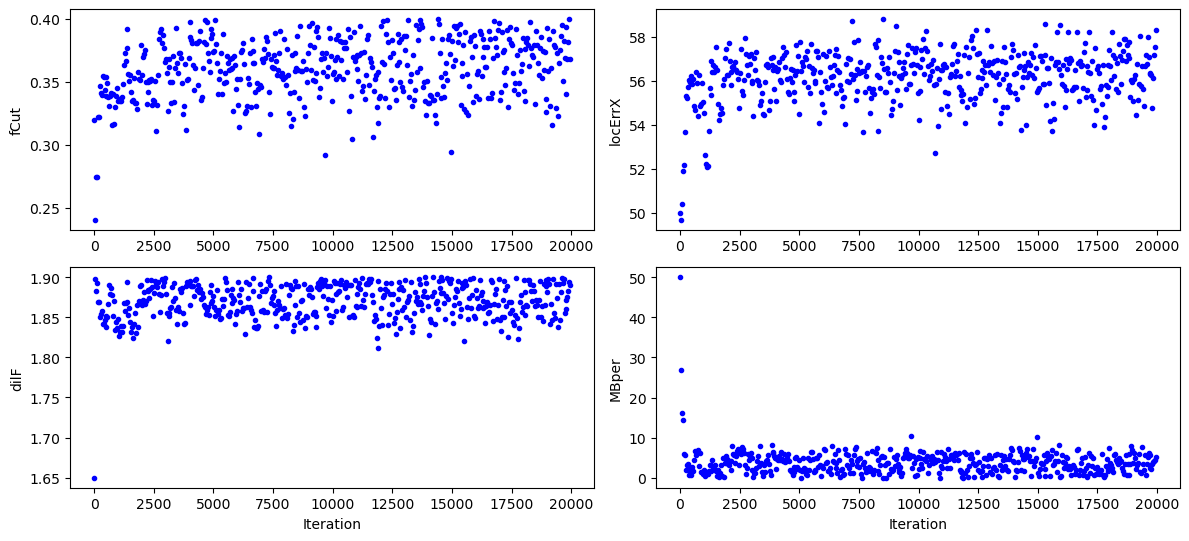

Estimated MCMC parameters


------------------------------
      name:      mean       std    MC_err       tau    geweke
      fCut:      0.36      0.02  1.44e-03     42.02      0.99
   locErrX:     56.29      0.98      0.06     44.23      1.00
      dilF:      1.87      0.02  1.26e-03     43.72      1.00
     MBper:      3.53      2.01      0.13     35.99      0.89
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 5.50%
Stage 2: 40.38%
Net    : 45.88% -> 9176/20000
---------------
Chain provided:
Net    : 52.74% -> 6593/12500
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


C:\Users\sangjin\AppData\Local\anaconda3\Lib\site-packages\pymcmcstat\plotting\MCMCPlotting.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=1.0)  # adjust spacing


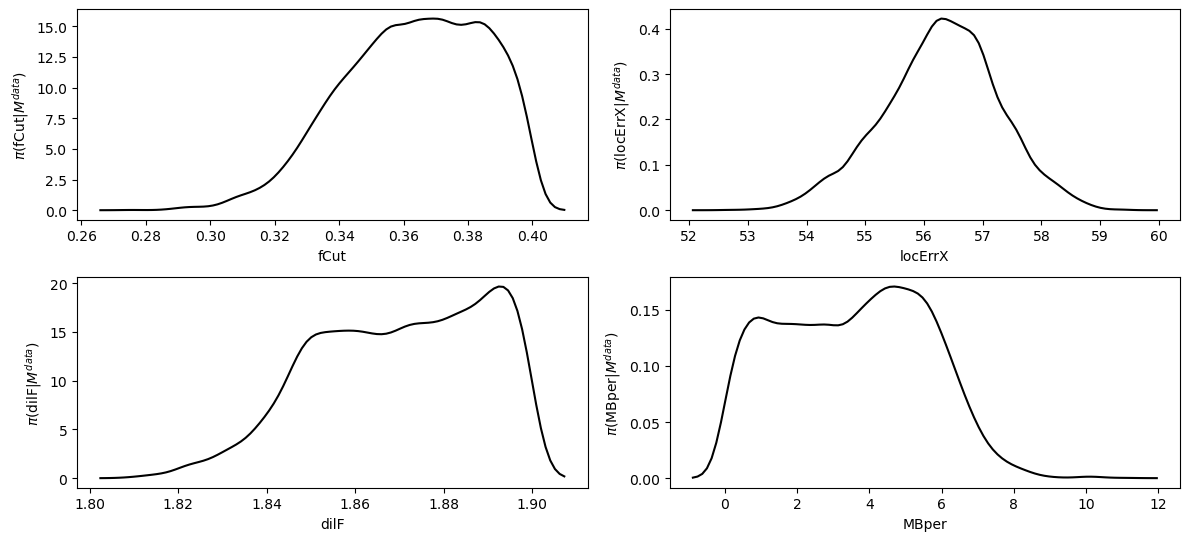

----------------------------------------------------------------------------------------------------


In [7]:
wids, edges, xNormInput = get_data(name='SK407', bin_num=50, verbose=True) 
args = dict(
    wid=wids, 
    edges=edges, 
    xNormInput=xNormInput,
    lb_=lb_orig, 
    ub_=ub_orig, 
    pnames=param_names_orig,
    nsimu = 20000,
    burnin = 7500,
)
mcstat = run_analysis(**args)

### Run Multiple

Analyzing for  SK455yw 3"MTS
there are 80 bad data points, removing them
total samples : 224272
wid =  1.0804877757962643
----------------------------------------------------------------------------------------------------

Executing fmin search
Optimization terminated successfully.
         Current function value: 0.000545
         Iterations: 121
         Function evaluations: 211

Estimated fmin parameters


fCut         0.283902
locErrX     47.591408
dilF         1.518675
MBper      100.000000
dtype: float64

----------------------------------------------------------------------------------------------------

running MCMC

Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      fCut:      0.32 [     0.24,      0.40] N( 0.00e+00,      inf)
   locErrX:     50.00 [    20.00,     80.00] N( 0.00e+00,      inf)
      dilF:      1.65 [     1.40,      1.90] N( 0.00e+00,      inf)
     MBper:     50.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 20000 of 20000 complete in 39.8 sec

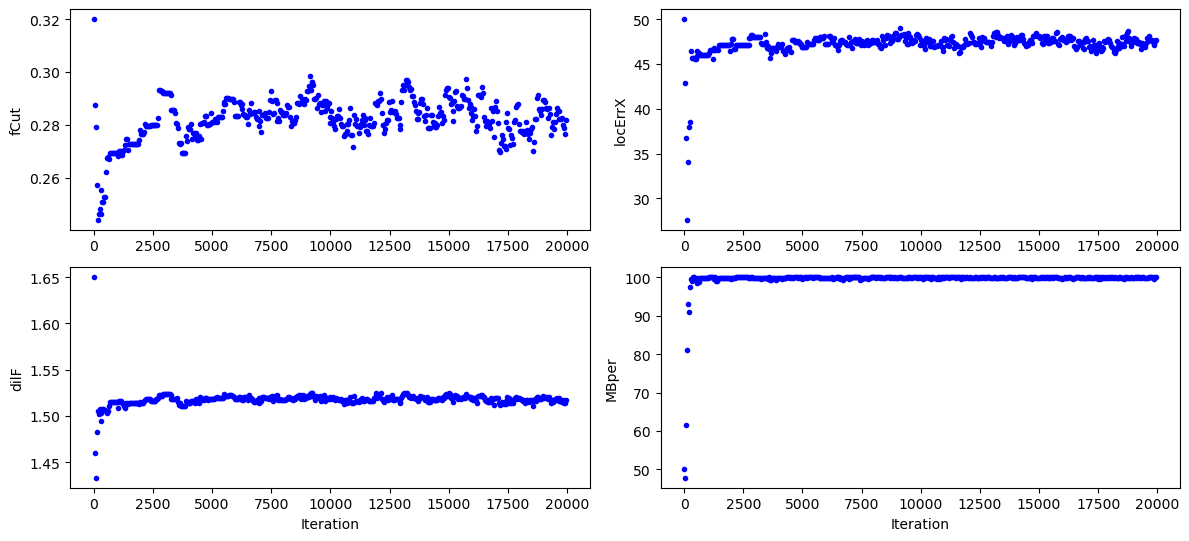

Estimated MCMC parameters


------------------------------
      name:      mean       std    MC_err       tau    geweke
      fCut:      0.28  5.29e-03  8.01e-04    465.96      0.99
   locErrX:     47.49      0.47      0.06    405.78      1.00
      dilF:      1.52  2.53e-03  3.44e-04    358.28      1.00
     MBper:     99.88      0.11  5.70e-03     41.34      1.00
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 0.28%
Stage 2: 5.55%
Net    : 5.83% -> 1166/20000
---------------
Chain provided:
Net    : 6.28% -> 942/15000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


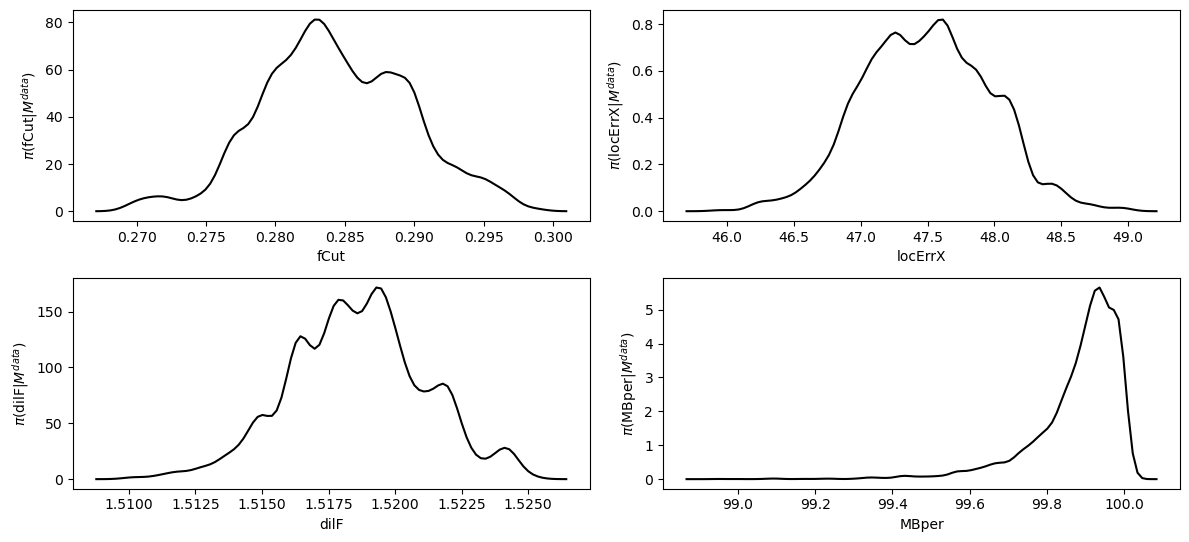

----------------------------------------------------------------------------------------------------
Analyzing for  SK455sucYW 3prime MTS, Yu-Huan
there are 441 bad data points, removing them
total samples : 515075
wid =  0.965149301762676
----------------------------------------------------------------------------------------------------

Executing fmin search
Optimization terminated successfully.
         Current function value: 0.000289
         Iterations: 156
         Function evaluations: 270

Estimated fmin parameters


fCut        0.288400
locErrX    59.162569
dilF        1.660246
MBper      80.206348
dtype: float64

----------------------------------------------------------------------------------------------------

running MCMC

Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      fCut:      0.32 [     0.24,      0.40] N( 0.00e+00,      inf)
   locErrX:     50.00 [    20.00,     80.00] N( 0.00e+00,      inf)
      dilF:      1.65 [     1.40,      1.90] N( 0.00e+00,      inf)
     MBper:     50.00 [ 0.00e+00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 20000 of 20000 complete in 67.8 sec

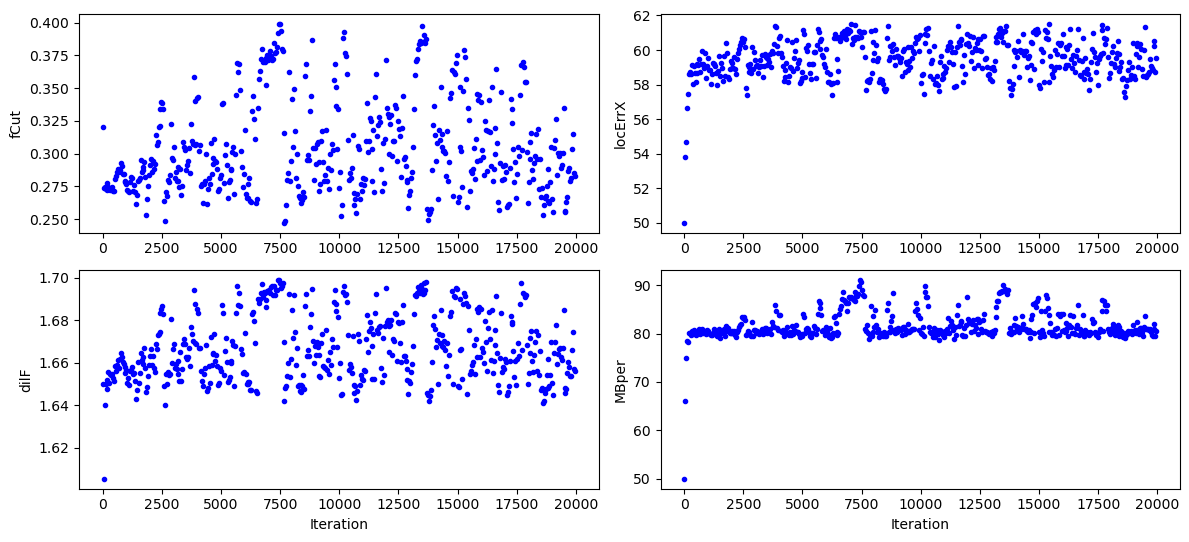

Estimated MCMC parameters


------------------------------
      name:      mean       std    MC_err       tau    geweke
      fCut:      0.31      0.04  4.25e-03    233.84      0.96
   locErrX:     59.62      1.02      0.09    130.31      1.00
      dilF:      1.67      0.02  1.66e-03    189.52      1.00
     MBper:     82.08      2.74      0.36    305.89      0.99
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 3.37%
Stage 2: 37.13%
Net    : 40.51% -> 8101/20000
---------------
Chain provided:
Net    : 40.90% -> 6135/15000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


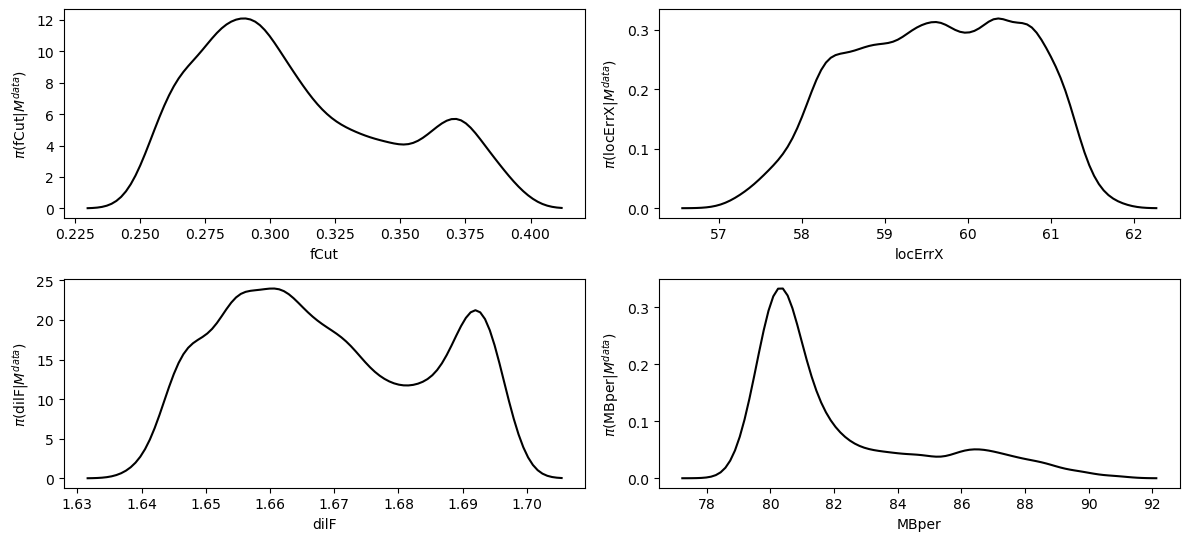

----------------------------------------------------------------------------------------------------


In [9]:
#names = ['SK187','SK292','SK407']
#names = ['SK187','SK466','SK467','SK598']
#names = ['SK374','SK507','SK592','SK404']
#names =['SK455yw','SK424yw','SK425yw']

#names = ['SK466','SK466sucYW 2pix']
#names = ['SK424yw','SK424sucYW']
#names = ['SK187','SK187sucYW_2pix']
names = ['SK455yw','SK455sucYW']

args =dict(
    lb_=lb_orig, 
    ub_=ub_orig, 
    pnames=param_names_orig,
    nsimu = 20000,
    burnin = 5000)

res = {}
for name in names:
    wids, edges, xNormInput = get_data(name=name, bin_num=50, verbose=True) 
    mcs = run_analysis(**dict(wid=wids, edges=edges, xNormInput=xNormInput, **args))
    results = mcs.simulation_results.results
    res[name] = results['chain'][5000:][:, 3]
    
    

In [10]:
#quantiles 95% CI lower bound and upper bound
pd.concat([
    pd.DataFrame(res).quantile(0.025),
    pd.DataFrame(res).quantile(0.975)], axis=1, keys=['2.5%', '97.5%'])

,2.5%,97.5%
SK455yw,99.573534,99.997906
SK455sucYW,79.301749,88.801967


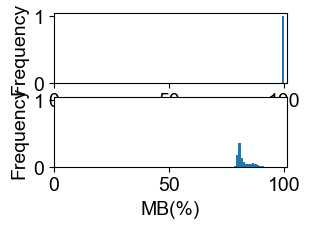

In [11]:
import seaborn as sns
import pandas as pd
# Set font properties
plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

res_df = pd.DataFrame(res)
_, ax = plt.subplots(2, 1, figsize=(3,2))

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 101)
custom_ylim = (0, 1.05)

for i, c in enumerate(res_df.columns):
    res_df[c].plot.hist(bins=np.arange(0, 101,1), density=True, ax=ax[i], xlim=custom_xlim, ylim=custom_ylim,stacked=True)
    
plt.xlabel('MB(%)')
plt.savefig('test.eps', format='eps')